### Workstream #1: Questions 9 - 12 (Mali)

Import all necessary packages

In [1]:
# Apache parquet files (to save space)
import pyarrow as pa
import pyarrow.parquet as pq
from fastparquet import ParquetFile

# Dataframes and numerical
import pandas as pd
import numpy as np

# Increase pandas default display 
pd.options.display.max_rows = 250
pd.options.display.max_columns = 250

# Suppress scientific notation of data in pandas
pd.set_option('display.float_format', '{:.2f}'.format)

# Graphing
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
from matplotlib.legend import Legend
from matplotlib.colors import TwoSlopeNorm
%matplotlib inline
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

import os
from scipy import stats

from tqdm.auto import tqdm

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20

from google.cloud import bigquery

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'viamo-datakind-19b12e3872f5.json'
bq_client = bigquery.Client()

import qgrid

In [2]:
def show_table(df):
    return qgrid.show_grid(df, show_toolbar=True)

Load **.parquet** file of all Mali caller data into **pandas** dataframe.

In [3]:
pf = ParquetFile('Viamo_user_data_Mali.parquet') 
df = pf.to_pandas()

Understand the structure of the dataframe.

In [4]:
df.head()

,subscriber_id,age,gender,n_calls,n_themes,n_topics,median_call_duration,gender_numeric,age_numeric,fav_theme,second_fav_theme,fav_topic,second_fav_topic,fav_theme_numeric,second_fav_theme_numeric,fav_topic_numeric,second_fav_topic_numeric
0,1057771709358727168,over_44,male,137,13,9,15.00,1.00,5.00,,news,,coronavirus,-1,1.00,-1,4.00
1,1258538143272463944,25_34,male,582,13,10,26.00,1.00,3.00,,health,,"coronavirus,malaria",-1,2.00,-1,3.00
2,968619422640562176,None,male,62,13,7,24.00,1.00,-1.00,,news,,"coronavirus,malaria",-1,1.00,-1,3.00
3,1066108357532246016,under_18,male,62,13,6,17.00,1.00,1.00,,health,,coronavirus,-1,2.00,-1,4.00
4,1192055677020335632,under_18,male,1447,13,9,6.00,1.00,1.00,,news,,coronavirus,-1,1.00,-1,4.00


In [5]:
df.shape

(2341867, 17)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2341867 entries, 0 to 2341866
Data columns (total 17 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   subscriber_id             Int64  
 1   age                       object 
 2   gender                    object 
 3   n_calls                   Int64  
 4   n_themes                  Int64  
 5   n_topics                  Int64  
 6   median_call_duration      float64
 7   gender_numeric            float64
 8   age_numeric               float64
 9   fav_theme                 object 
 10  second_fav_theme          object 
 11  fav_topic                 object 
 12  second_fav_topic          object 
 13  fav_theme_numeric         int64  
 14  second_fav_theme_numeric  float64
 15  fav_topic_numeric         int64  
 16  second_fav_topic_numeric  float64
dtypes: Int64(4), float64(5), int64(2), object(6)
memory usage: 330.5+ MB


In [7]:
df.dtypes

subscriber_id                 Int64
age                          object
gender                       object
n_calls                       Int64
n_themes                      Int64
n_topics                      Int64
median_call_duration        float64
gender_numeric              float64
age_numeric                 float64
fav_theme                    object
second_fav_theme             object
fav_topic                    object
second_fav_topic             object
fav_theme_numeric             int64
second_fav_theme_numeric    float64
fav_topic_numeric             int64
second_fav_topic_numeric    float64
dtype: object

This **.parquet file** is that which had already been cleaned and feature engineered to assist with the clustering analysis (**Workstream #4**), so there shall be far less errata in it and the study shall be simpler.

### Question 9: Assessing field sparsity - what percentage of a given variable response is nulls?

In [9]:
(df.isnull().sum()/len(df)*100).sort_values(ascending=False)

age                        49.83
gender                     43.39
second_fav_topic           28.03
second_fav_theme           13.01
subscriber_id               0.00
fav_topic_numeric           0.00
second_fav_theme_numeric    0.00
fav_theme_numeric           0.00
fav_topic                   0.00
age_numeric                 0.00
fav_theme                   0.00
gender_numeric              0.00
median_call_duration        0.00
n_topics                    0.00
n_themes                    0.00
n_calls                     0.00
second_fav_topic_numeric    0.00
dtype: float64

Above information shows the percentage of null vales for each variables. The highest number of nulls is that for **age** (almost half), followed by **gender** (more than two-fifths), and then **second-favorite topic** (more than a quarter) and **second-favorite theme** (slightly more than an eighth).

It suggests that gender and age are pieces of information that the callers do not record. Perhaps it is something that they do not want to admit or a piece of information that they find too personal?

One hypothesis comes from the common adage never to ask a woman her age. Is it true in this case?

In [27]:
# Percentage of men who decline to state their age:
age_shy_xy = [len(df.loc[(df.gender=='male') & (df.age.isna())]),
              len(df.loc[df.gender=='male']) - len(df.loc[(df.gender=='male') & (df.age.isna())])]

# Percentage of women who decline to state their age:
age_shy_xx = [len(df.loc[(df.gender=='female') & (df.age.isna())]),
              len(df.loc[df.gender=='female']) - len(df.loc[(df.gender=='female') & (df.age.isna())])]

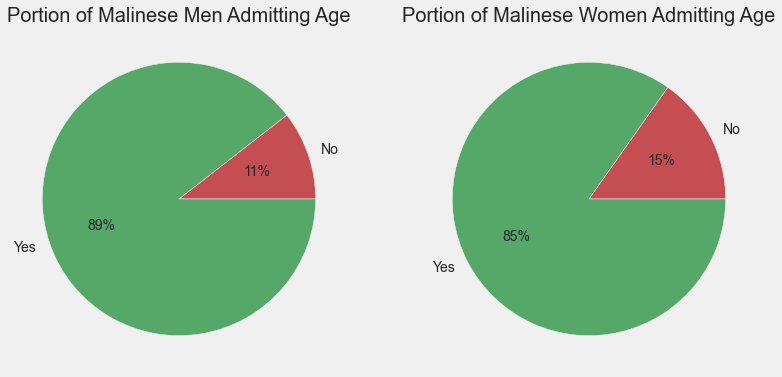

In [37]:
plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plt.pie(age_shy_xy, colors=['#c44e52','#55a868'], labels = ["No", "Yes"], autopct='%.0f%%')
plt.title('Portion of Malinese Men Admitting Age')

plt.subplot(1, 2, 2)
plt.pie(age_shy_xx, colors=['#c44e52','#55a868'], labels = ["No", "Yes"], autopct='%.0f%%')
plt.title('Portion of Malinese Women Admitting Age')

plt.show()

Predictably, women more so than men are reluctant to admit their age, but not be a large percentage.

So, which age groups are least likely to admit their gender, if that is worth examining?

In [36]:
df.age.value_counts()

18_24       385156
25_34       290523
under_18    277822
35_44       132757
over_44      88629
Name: age, dtype: int64

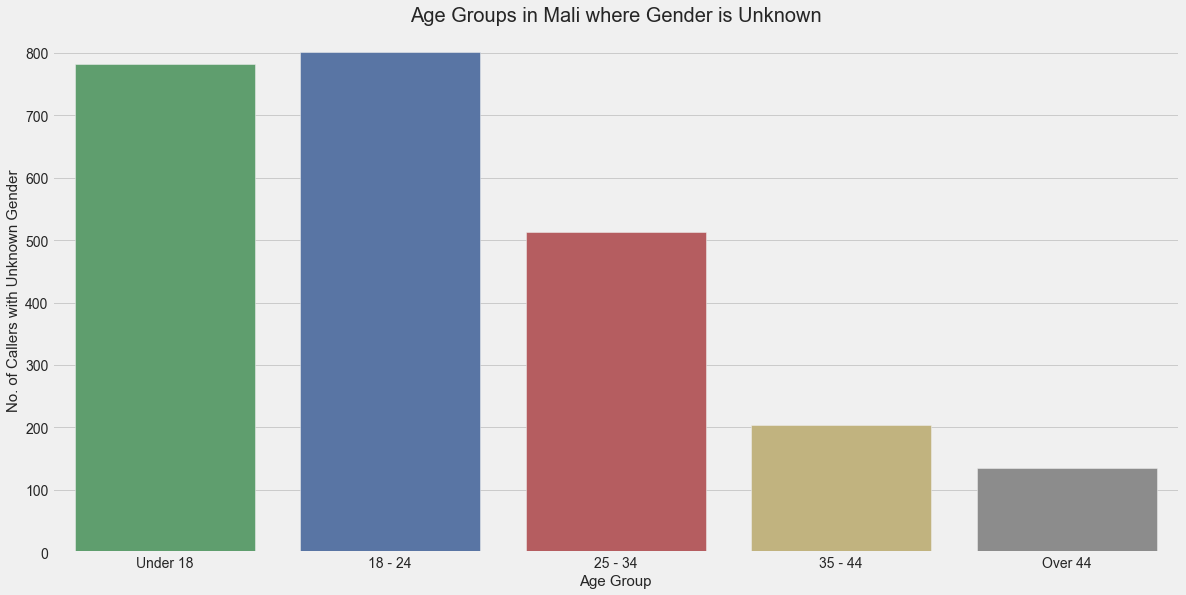

In [58]:
# Specify order of categories in plot
order = ['under_18','18_24','25_34','35_44','over_44']
label = ['Under 18', '18 - 24', '25 - 34', '35 - 44', 'Over 44']
color = ['#55a868', '#4c72b0', '#c44e52', '#ccb974', '#8c8c8c']

# Creating seaborn countplot
plt.figure(figsize=(18,9))
g = sns.countplot(x = df.age.loc[df.gender.isna()], data = df, order = order, palette = color)

# Plot formatting
# g.set_yticks(list(range(0,100,1100)))
# g.yaxis.set_major_formatter(StrMethodFormatter('{x:,}'))
g.set_xticklabels(label)
# plt.legend(prop={'size': 14})
plt.title('Age Groups in Mali where Gender is Unknown')
plt.xlabel('Age Group')
plt.ylabel('No. of Callers with Unknown Gender')
plt.show()

Younger age groups are more likely to withhold gender information compared to older ones.